In [1]:
import os 
import sys
import math
import torch
import pickle
import optuna
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score
import seaborn as sn
%matplotlib inline

sys.path.append("..")
from metric.metric import metric

data_folder = '../data/'
np.random.seed(2022)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load temporal & spatial features

In [2]:
# Load extracted features from temporal and spatial module 
# commit and uncommit following code to select model for temporal and spatial module

# for logistics regression 
# pkl_filename = "./temp_results/temporal_spatial_proba_lr.pkl"

# for Fully connected network 
pkl_filename = "./temp_results/temporal_spatial_proba_FCN.pkl"
with open(pkl_filename, 'rb') as file:
    proba_df = pickle.load(file)

In [3]:
proba_df[['LU3']] = [[int(c[0].lstrip('LU'))] for c in proba_df[['LU3']].values]
proba_df[['LC3']] = [[int(c[0].lstrip('LC'))] for c in proba_df[['LC3']].values]

In [4]:
proba_df.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.319364,0.680636,0,41,301
48611112,0.847969,0.152031,0,61,402
48621113,0.356399,0.643601,0,47,103
48621114,0.876144,0.123856,0,12,106
48621115,0.339232,0.660768,1,15,142


# Load image-level prediction data

In [5]:
# Load image classification results
pred_lc = pd.read_csv(os.path.join(data_folder, 'predictions_lc_area4.csv'), index_col=0)
pred_lc.rename(columns={"prediction": "prediction_lc", "confidence": "confidence_lc"}, inplace=True)
pred_lu = pd.read_csv(os.path.join(data_folder, 'predictions_lu_area4.csv'), index_col=0)
pred_lu.rename(columns={"prediction": "prediction_lu", "confidence": "confidence_lu"}, inplace=True)
pred = pd.concat([pred_lc, pred_lu], axis=1)

In [6]:
data_merged = pred.merge(proba_df, on="RELI")
data_merged.head()

,prediction_lc,confidence_lc,11,12,13,14,15,16,17,21,...,403,421,422,423,424,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,,,,,,,,,,,,,,,,,
49951581,41,76.953766,0.000009,7.618940e-07,2.099650e-08,8.110239e-08,0.000001,8.325645e-07,4.026339e-08,0.000038,...,0.000005,0.000285,0.000542,9.374106e-06,9.187247e-08,0.284680,0.715320,0,41,301
49981581,44,78.772316,0.039818,2.334603e-04,2.323926e-05,2.072141e-05,0.002156,6.963758e-04,1.789809e-04,0.009756,...,0.001540,0.017287,0.003396,3.867370e-03,5.498816e-05,0.257959,0.742041,0,41,301
49991582,44,67.986916,0.002073,1.667959e-05,1.380497e-06,1.529333e-06,0.000817,2.182389e-04,1.651016e-05,0.001084,...,0.000794,0.001990,0.005905,2.115689e-03,2.773002e-05,0.284680,0.715320,0,41,301
50151581,21,85.930080,0.008901,7.979578e-04,5.665574e-06,1.838485e-04,0.005638,3.700416e-05,3.987769e-04,0.859301,...,0.000004,0.004689,0.000027,1.708885e-03,6.309299e-04,0.549609,0.450391,0,21,242
50161581,41,97.562386,0.000271,4.466186e-05,8.621574e-07,1.826270e-06,0.000045,1.239971e-05,2.361364e-06,0.000080,...,0.000008,0.000023,0.000048,7.809795e-07,4.363787e-08,0.355896,0.644104,0,41,301


In [7]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask], data_to_split[~mask]]

In [8]:
train, test = split_set(data_merged)
train, val = split_set(train)

train_label = train.changed
train_features = train.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

val_label = val.changed
val_features = val.drop('changed', axis=1)
print('Length of the val dataset : {}'.format(len(val)))

test_label = test.changed
test_features = test.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 222513
Length of the val dataset : 55646
Length of the test dataset : 70265


# load RF model

In [16]:
class Classsifers():
    
    def __init__(self, train_x, train_y, val_x, val_y, classifers, study_name, n_trials=20):
        '''
        init the finetuning of multiple classifiers
        @params:
        train_x: input training features
        train_y: ground-truth label of training set
        ...
        classifiers: name of classifier to optimize
        '''
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self._classsifers = classifers
        self.n_cpus = int(os.cpu_count() - 4)
        self.n_trials = n_trials
        self.study_name = study_name
        self.storage_name = "sqlite:///{}.db".format(study_name)
        self.acc_mean = 0
        self.study = optuna.create_study(study_name=self.study_name, direction='maximize', storage=self.storage_name, load_if_exists=True)
        try:
            # if os.path.exists('./{}.db'.format(study_name)):
            self.best_opt_metric = self.study.best_value
            self._best_params = self.study.best_params
        except ValueError:
            pass
            
        
    def objective(self, trial):
        # define the tuning object with fields and range of the hyper params
        classsifer = trial.suggest_categorical('classsifer', self._classsifers)

        if classsifer == 'RandomForest':
            # cf. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

            params = dict(
                criterion = trial.suggest_categorical('criterion', ["gini", "entropy", "log_loss"]),
                bootstrap = True,
                max_depth = trial.suggest_int('max_depth', 10, 1000),
                oob_score = True,
                max_features = trial.suggest_categorical('max_features', [None, 'sqrt','log2']),
                min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
                min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10),
                n_estimators = int(trial.suggest_float('n_estimators', 1000, 8000, step=500)),
                # class_weight = 'balanced_subsample',
                n_jobs=self.n_cpus
            )
            model = RandomForestClassifier(**params)
            model.fit(self.train_x, self.train_y)
            
            acc_mean = f1_score(self.val_y, model.predict(self.val_x), average='macro')

        else:
            raise Exception('Invalid regressor. Only the following choices are valid: "RandomForest".')

        return acc_mean
        
    def optimize(self, cv=5):
        # hyper params tuning with Optuna
        # detailed explanation of Optuna: https://optuna.org/

        # self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=max(self.n_cpus, 1))
        self.study.optimize(self.objective, n_trials=self.n_trials, n_jobs=1)
                            
        # /!\ we need to make sure that type(n_estimators) == 'int'
        best_params = self.study.best_params.copy()
        best_params['n_estimators'] = int(best_params['n_estimators'])
        print("Best parameters:", best_params)
        print("Best score (mean balanced_accuracy after 5-fold Cross Validation):", self.study.best_value)
        self._best_params = best_params
        self.best_opt_metric = self.study.best_value

        
    def compute_confusion_matrix(self): 
    
        TP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==1))
        TN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==0))
        FP = np.sum(np.logical_and(self._predict_label_test==1, self._true_label_test==0))
        FN = np.sum(np.logical_and(self._predict_label_test==0, self._true_label_test==1))

        self._confusion_matrix = np.asarray([[TP, FP],
                                        [FN, TN]])
        return self._confusion_matrix


    def plot_confusion_matrix(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix
        label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                            ['FN {}'.format(FN), 'TN {}'.format(TN)]])

        df_cm = pd.DataFrame(self._confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

        sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion matrix')



    def compute_score(self):
        [[TP, FP],[FN, TN]] = self._confusion_matrix.astype(float)

        accuracy =  (TP+TN)/np.sum(self._confusion_matrix)

        precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
        precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan

        recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
        recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

        F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
        F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan
        
        balanced_acc = (recall_positive + recall_negative) / 2

        print("The accuracy of model is {:1.3f}".format(accuracy))
        print("The balanced accuracy of model is {:1.3f}".format(balanced_acc))
        print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_positive, recall_positive, F1_score_positive))
        print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
              .format(precision_negative, recall_negative, F1_score_negative))

        return {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'precision_positive': precision_positive,
            'recall_positive': recall_positive,
            'F1_score_positive': F1_score_positive,
            'precision_negative': precision_negative,
            'recall_negative': recall_negative,
            'F1_score_negative': F1_score_negative
        }

        
    def best_model(self):
        # init the best model with optimized params
        params_dict = self._best_params.copy()
        cls_best = params_dict.pop('classsifer')
        if cls_best == 'RandomForest':
            params_dict['n_estimators'] = int(params_dict['n_estimators'])
            best_model = RandomForestClassifier(**params_dict, n_jobs=self.n_cpus)
        print(params_dict)
                
        best_model.fit(self.train_x, self.train_y)
        score = cross_val_score(best_model, self.train_x, self.train_y, cv=5, scoring="balanced_accuracy")
        self.score = score.mean()
        self.best_model = best_model
        
        print('Best model initialized with macro average F1-score: {:.3f} \n'.format(self.score))

    
    def _evaluate(self, test_x, test_y):
        # evaluate the performance of given test data
        self._true_label_test = test_y
        self._predict_label_test = self.best_model.predict(test_x)
        acc_balanced = balanced_accuracy_score(self._true_label_test, self._predict_label_test)
        
        return acc_balanced
        
    
    def save_model(self, path):
        # Save to file in the current working directory
        with open(path, 'wb') as file:
            pickle.dump(self.best_model, file)
        
    
    def load_model(self, path):
        # Load from file
        with open(path, 'rb') as file:
            self.best_model = pickle.load(file)
        

In [12]:
test_cls = Classsifers(train_x=train_features, train_y=train_label, val_x=val_features, val_y=val_label,
                       classifers=['RandomForest'], study_name='FCN-RandomForest-integrate', n_trials=200)

[I 2022-12-19 13:20:52,384] Using an existing study with name 'integration_change_proba' instead of creating a new one.


In [ ]:
test_cls.optimize()

In [14]:
test_cls._best_params

{'classsifer': 'RandomForest',
 'max_depth': 488,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 7,
 'n_estimators': 2000.0}

In [13]:
test_cls.best_opt_metric

0.7947832998159647

In [ ]:
test_cls.best_model()

{'max_depth': 488, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 2000}


In [15]:
test_cls.load_model('./FCN-RandomForest-integrate.pkl')

In [43]:
test_cls.save_model('./FCN-RandomForest-integrate.pkl')

In [13]:
prediction_proba = test_cls.best_model.predict_proba(test_features)

In [14]:
# build df_change for ML model
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = prediction_proba[:,1]
df_change.reset_index(inplace=True)

In [19]:
# Metric mode 'multi' uses change probability and image-level prediction as input together 
metric(mode='multi', PROBABILITY_THRESHOLD=0.09, change_pred=df_change, lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index())

Length of filtered data: 47588
balanced accuracy: 0.752
recall: 0.969
true negative rate: 0.535
missed changes: 241
missed changes w.r.t total changes: 0.031
missed weighted change: 10810
missed weighted changes w.r.t total weighted changes: 0.020
automatized points: 21567
automatized capacity: 0.541
raw metric: 0.372
weighted metric: 0.434


[0.09,
 241,
 0.03125,
 10810.0,
 0.01971638320186038,
 21567,
 0.5408516400842612,
 0.37183550255792963,
 0.4342152581717016]

In [16]:
threshold = np.linspace(0, 1, 101)
columns_score_name = ['Threshold', 'miss_changes', 'miss_changed_ratio', 'miss_weighted_changes', 'miss_weighted_changed_ratio', 
            'automatized_points', 'automatized_capacity', 'raw_metric', 'weighted_metric']
threshold_score = pd.concat([pd.DataFrame([metric(mode='multi', PROBABILITY_THRESHOLD=t, change_pred=df_change, 
                                                  lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index(), print_log=False)],
                                          columns=columns_score_name) for t in threshold],
                            ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'weighted_metric')

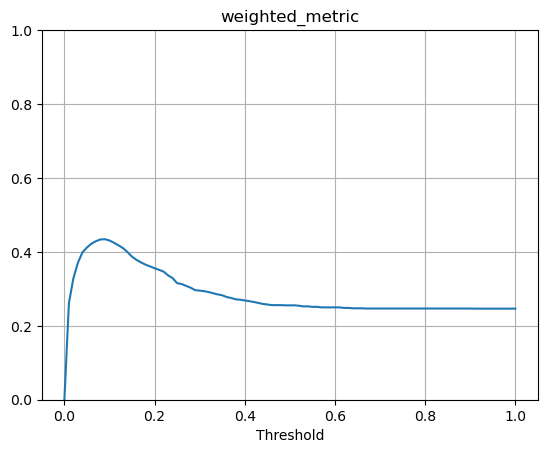

In [17]:
threshold_score['weighted_metric'].plot(grid=True, ylim=[0,1]).set_title('weighted_metric')

In [18]:
threshold_score.iloc[threshold_score['weighted_metric'].argmax()]

miss_changes                     241.000000
miss_changed_ratio                 0.031250
miss_weighted_changes          10810.000000
miss_weighted_changed_ratio        0.019716
automatized_points             21567.000000
automatized_capacity               0.540852
raw_metric                         0.371836
weighted_metric                    0.434215
Name: 0.09, dtype: float64

In [52]:
thred = threshold_score.iloc[threshold_score['weighted_metric'].argmax()].name
thred

0.12

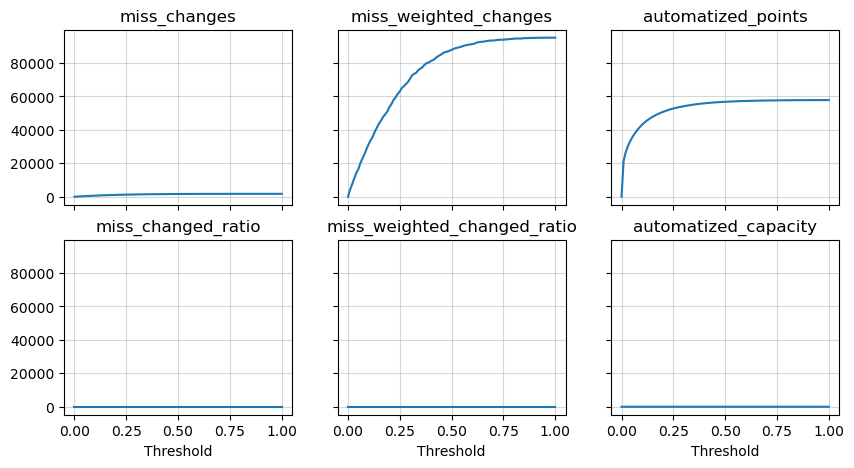

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['miss_changes', 'miss_weighted_changes', 'automatized_points',
            'miss_changed_ratio','miss_weighted_changed_ratio',  'automatized_capacity']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)

# load data for pytorch model

In [9]:
X_train = torch.Tensor(train_features.values).cuda()
y_train = torch.Tensor(train_label.values).cuda()

X_val = torch.Tensor(val_features.values).cuda()
y_val = torch.Tensor(val_label.values).cuda()

X_test = torch.Tensor(test_features.values).cuda()
y_test = torch.Tensor(test_label.values).cuda()

In [10]:
class FCN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, 1024)
        self.fc6 = nn.Linear(1024, 512)
        self.fc7 = nn.Linear(512, output_dim)

        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))   
        
        return x

In [11]:
network_in = './integrate-lr-fcn/ckpt-0.95-4/ckpt-135.pth'

input_dim = len(test_features.columns)
output_dim = 1 

model = FCN(input_dim, output_dim).cuda()

model.load_state_dict(torch.load(network_in), strict=True)
model = model.cuda()

# Calculating the loss and accuracy for the validation dataset
outputs_test = torch.squeeze(model(X_test))

In [12]:
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = outputs_test.cpu().detach().numpy()
df_change.reset_index(inplace=True)

In [13]:
metric(mode='multi', PROBABILITY_THRESHOLD=0.5, change_pred=df_change, lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index())

Length of filtered data: 47588
balanced accuracy: 0.742
recall: 0.970
true negative rate: 0.514
missed changes: 228
missed changes w.r.t total changes: 0.030
missed weighted change: 10335
missed weighted changes w.r.t total weighted changes: 0.019
automatized points: 20739
automatized capacity: 0.520
raw metric: 0.366
weighted metric: 0.422


[0.5,
 0.742402615119318,
 0.9704356846473029,
 0.5143695455913332,
 228,
 0.029564315352697094,
 10335.0,
 0.01885002963841138,
 20739,
 0.5200872705386699,
 0.36632702976738263,
 0.4220506658965258]